<a href="https://colab.research.google.com/github/ICT-Deeper/main/blob/main/%ED%86%B5%ED%95%A9%EC%BD%94%EB%93%9C_BIM_cifar10_both_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install numpy tensorflow opencv-python-headless

In [10]:
#BIM 소스코드
#BIM=Basic Iterative Method
#FGSM의 확장으로 FGSM을 여러번반복하면서 각 단계에서 생성된 적대적 예제에 조금씩 노이즈를 추가..
#여러번공격을

In [11]:
#import the necessary packages
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import MSE
from tensorflow.keras.layers import BatchNormalization, Conv2D, Activation, Flatten, Dropout, Dense
from google.colab.patches import cv2_imshow
from google.colab import drive
import os

In [12]:
# 저장하기 위해 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
class SimpleCNN:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # first CONV => RELU => BN layer set
        model.add(Conv2D(32, (3, 3), strides=(2, 2), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))

        # second CONV => RELU => BN layer set
        model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(128))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        return model

In [14]:
# [dataset_type] 0:cifar10, 1:cifar100
# [model_type] 0:DNN, 1:CNN
class AdvSampler():
    def __init__(self, dataset_type=0, model_type=1, name='abc', targeted=False, target_label=None):
        self.dataset_type = dataset_type
        self.model_type = model_type
        self.targeted = targeted
        self.target_label = target_label
        self.labels_cifar10 = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
        self.name = name
        self.model_path = '/content/drive/My Drive/models/'  # Update path in Google Drive
        self.Initialize()

    def Initialize(self):
        self.load_dataset()
        self.data_preprocessing()
        self.build_model()

    def load_dataset(self):
        if self.dataset_type == 0:
            print("[INFO] loading CIFAR-10 dataset...")
            (self.trainX, self.trainY), (self.testX, self.testY) = cifar10.load_data()

    def data_preprocessing(self):
        self.trainX = self.trainX / 255.0
        self.testX = self.testX / 255.0
        self.trainX = np.expand_dims(self.trainX, axis=-1)
        self.testX = np.expand_dims(self.testX, axis=-1)
        self.trainY = to_categorical(self.trainY, 10)
        self.testY = to_categorical(self.testY, 10)

    def build_model(self):
        if self.dataset_type == 0:
            self.model = SimpleCNN.build(width=32, height=32, depth=3, classes=10)

        print("[INFO] compiling model...")
        self.opt = Adam(learning_rate=1e-3)
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    def train_evaluate_model(self, epochs=10, batch_size=64):
        print("[INFO] training network...")
        self.model.fit(self.trainX, self.trainY, validation_data=(self.testX, self.testY), batch_size=batch_size, epochs=epochs, verbose=1)

        print("[INFO] evaluating network...")
        (loss, acc) = self.model.evaluate(x=self.testX, y=self.testY, verbose=0)
        print("[INFO] loss: {:.4f}, acc: {:.4f}".format(loss, acc))

    # BIM 공격을 통해 적대적 예제 생성
    #BIM구현을 위해 nun_iter라는 변수를 추가하여 FGSM을 여러 번 반복 적용..
    # alpha크기만큼 업데이트 되며, 전체 노이즈 크기는 eps를 넘지 않도록 제한
    def generate_adversary(self, image, label, eps=2 / 255.0, alpha=1 / 255.0, num_iter=10):
        image = tf.cast(image, tf.float32)
        perturbed_image = image

        for i in range(num_iter):
            with tf.GradientTape() as tape:
                tape.watch(perturbed_image)
                pred = self.model(perturbed_image)
                loss = MSE(label, pred)

            gradient = tape.gradient(loss, perturbed_image)
            signedGrad = tf.sign(gradient)

            perturbed_image = perturbed_image + alpha * signedGrad
            perturbation = tf.clip_by_value(perturbed_image - image, -eps, eps)
            perturbed_image = tf.clip_by_value(image + perturbation, 0, 1)

        return perturbed_image

    # 적대적 예제 생성 및 GAN 복원
    #BIM관련 매게변수를 전달해서 적대적 예제 생성
    def my_generator(self, max_iterations=100, num_iter=10, alpha=2/255.0):
        for i in np.random.choice(np.arange(0, len(self.testX)), size=(10,)):
            image = self.testX[i]
            label = self.testY[i]
            adversary = image.reshape(1, 32, 32, 3)

            iteration = 0
            while iteration < max_iterations:
                adversary = self.generate_adversary(adversary, label, eps=8/255.0, alpha=alpha, num_iter=num_iter)
                pred = self.model.predict(adversary)
                adversaryPred = pred[0].argmax()

                if adversaryPred != label.argmax():
                    break

                iteration += 1



            adversary = tf.reshape(adversary,(32, 32, 3)) * 255
            adversary = np.clip(adversary.numpy(), 0, 255).astype("uint8")

            image = image.reshape((32, 32, 3)) * 255
            image = image.astype("uint8")

            image = cv2.resize(image, (96, 96))
            adversary = cv2.resize(adversary, (96, 96))

            imagePred = label.argmax()
            adversaryPred = pred[0].argmax()
            color = (0, 255, 0)
            if imagePred != adversaryPred:
                color = (0, 0, 255)

            cv2.putText(image, str(imagePred), (2, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.95, (0, 255, 0), 2)
            cv2.putText(adversary, str(adversaryPred), (2, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.95, color, 2)


            output = np.hstack([image, adversary])
            cv2_imshow(output)
            cv2.waitKey(0)

    def run(self):
        self.train_evaluate_model()
        self.my_generator()


In [15]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[INFO] loading CIFAR-10 dataset...
[INFO] compiling model...
[INFO] training network...
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.3696 - loss: 1.9585 - val_accuracy: 0.5638 - val_loss: 1.2538
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5700 - loss: 1.2124 - val_accuracy: 0.5715 - val_loss: 1.1930
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6344 - loss: 1.0327 - val_accuracy: 0.6315 - val_loss: 1.0424
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6786 - loss: 0.9099 - val_accuracy: 0.6383 - val_loss: 1.0154
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7110 - loss: 0.8189 - val_accuracy: 0.6608 - val_loss: 0.9846
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7348 - loss: 0.7576 - val_accuracy: 0.6518 - val_loss: 1.0184
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7515 - loss: 0.7040 - val_accuracy: 0.6455 - val_loss: 1.0455
Epoch 8/10
782/

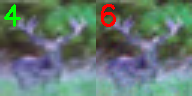

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


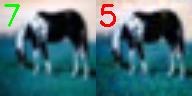

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


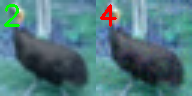

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


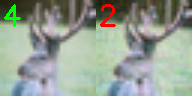

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


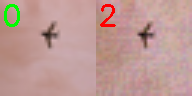

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


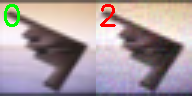

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


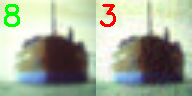

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


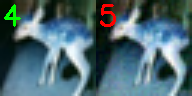

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


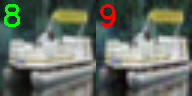

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


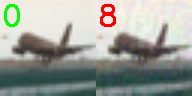

In [16]:
result = AdvSampler(name='test', targeted=True, target_label=3)
#★ result = AdvSampler(name='test', targeted=True, target_label=3) ***targted한 샘플을 생성하는 명령 (예시:target_label=3)***
#★ result = AdvSampler(name='test')  ***nontargted한 샘플을 생성하는 명령***
result.run()